# Лабораторна робота №4:Advanced Neural Nets. Маринін Іван Павло Ігорович, ФІ-32мн

Датасет: https://www.kaggle.com/datasets/mykras/ukrainian-texts
Franko_-Zibrannya-tvoriv-u-p-yatdesyati-tomah-literaturno-kritichni-praci-1900-1902-tom-33-.382254.txt

Завдання 1. Машинний переклад на базі трансформерів. 

In [1]:
import keras
from keras import layers
import numpy as np
import random
import io
import pathlib

In [2]:
path = pathlib.Path("D:/Універ/магістратура/1 семестр/Data Analysis/lab 4/Franko_-Zibrannya-tvoriv-u-p-yatdesyati-tomah-literaturno-kritichni-praci-1900-1902-tom-33-.382254.txt")

with io.open(path, encoding="utf-8") as f:
    text = f.read().lower()
text = text.replace("\n", " ")
print("Corpus length:", len(text))

chars = sorted(list(set(text)))
print("Total chars:", len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i : i + maxlen])
    next_chars.append(text[i + maxlen])
print("Number of sequences:", len(sentences))

x = np.zeros((len(sentences), maxlen, len(chars)), dtype="bool")
y = np.zeros((len(sentences), len(chars)), dtype="bool")
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Corpus length: 1055876
Total chars: 117
Number of sequences: 351946


In [3]:
model = keras.Sequential(
    [
        keras.Input(shape=(maxlen, len(chars))),
        layers.LSTM(128),
        layers.Dense(len(chars), activation="softmax"),
    ]
)
optimizer = keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(loss="categorical_crossentropy", optimizer=optimizer)

In [4]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [5]:
epochs = 30
batch_size = 128

for epoch in range(epochs):
    model.fit(x, y, batch_size=batch_size, epochs=1)
    print()
    print("Generating text after epoch: %d" % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print("...Diversity:", diversity)

        generated = ""
        sentence = text[start_index : start_index + maxlen]
        print('...Generating with seed: "' + sentence + '"')

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.0
            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]
            sentence = sentence[1:] + next_char
            generated += next_char

        print("...Generated: ", generated)
        print("-")


2750/2750 [==============================] - 237s 85ms/step - loss: 2.3196

Generating text after epoch: 0
...Diversity: 0.2
...Generating with seed: "рії і практиці, і він, незважаючи на пев"
...Generated:  ного видання про потресь старого видання потреба на серед про польського полість про серед і в коломитичного про про показії про не повідання старині статичні стартицький потрівники про додого про серед польський польського про серед на відних покрів про серед стати про серед такий полість право на повість на конів старицький польського полість і значення від серед повного про серед про серед від 
-
...Diversity: 0.5
...Generating with seed: "рії і практиці, і він, незважаючи на пев"
...Generated:  ної театра про підку про розві кніва, то правда та відність надрав на два собі право видання стати останна світованого трого польського відого словоних того і кнарі м. такого не деньших і театра.    проскали другого навіти любить до врого настіло те правдований польського своїх таків ві

2. Проведення експериментів з моделями бібліотеки HF Transformers (https://huggingface.co/) за допомогою Pipeline модуля.

In [6]:
from transformers import pipeline

classifier = pipeline('sentiment-analysis')
result = classifier('Це дуже чудовий приклад.')
print(result)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


D:\Anaconda\lib\site-packages\huggingface_hub\file_download.py:137: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\IvanPavlo\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


[{'label': 'POSITIVE', 'score': 0.8061551451683044}]


In [18]:
print(classifier(['Мені шкода, що сьогодні ти впав з велосипеда.', 
                  'У мене сьогодні настільки гарний настрій, що його не зіпсує навіть погода.',
                  'Погоді таки вдалося зіпсувати мій найкращий настрій.', 
                  'Сьогодні падав сніг.', 'Сьогодні не падав сніг', 'It snowed today.', 'It didn not snow today']))

[{'label': 'NEGATIVE', 'score': 0.7293701171875}, {'label': 'NEGATIVE', 'score': 0.7510843276977539}, {'label': 'POSITIVE', 'score': 0.6295129656791687}, {'label': 'POSITIVE', 'score': 0.677516758441925}, {'label': 'POSITIVE', 'score': 0.5312715768814087}, {'label': 'NEGATIVE', 'score': 0.9104232788085938}, {'label': 'POSITIVE', 'score': 0.7619729042053223}]


In [19]:
classifier = pipeline("zero-shot-classification")
classifier(["I study math at the university.", "Ukrainian politicians are not competent in their work."],
    candidate_labels=["education", "politics", "business"],)

No model was supplied, defaulted to roberta-large-mnli and revision 130fb28 (https://huggingface.co/roberta-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


All PyTorch model weights were used when initializing TFRobertaForSequenceClassification.

All the weights of TFRobertaForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


[{'sequence': 'I study math at the university.',
  'labels': ['education', 'politics', 'business'],
  'scores': [0.9011035561561584, 0.05308283120393753, 0.04581361636519432]},
 {'sequence': 'Ukrainian politicians are not competent in their work.',
  'labels': ['politics', 'business', 'education'],
  'scores': [0.9808955788612366, 0.011312667280435562, 0.0077917627058923244]}]

In [20]:
generator = pipeline("text-generation")
generator("To become a billionaire you need to")

No model was supplied, defaulted to gpt2 and revision 6c0e608 (https://huggingface.co/gpt2).
Using a pipeline without specifying a model name and revision in production is not recommended.


All PyTorch model weights were used when initializing TFGPT2LMHeadModel.

All the weights of TFGPT2LMHeadModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': "To become a billionaire you need to create an account for a business and give away money. You don't need to own any. But you do need to build a business by paying a commission. You also have to pay for its upkeep and upkeep costs"}]

Щодо українських мовних моделей, то вдалося знайти ukr-spacy модель https://huggingface.co/ukr-models/uk_core_news_trf із більш менш нормальним описом - https://github.com/kurnosovv/ukr-spacy. А також модель ukr-morph https://huggingface.co/ukr-models/uk-morph, скриншот до якої з HuggingFace наведено нижче. 

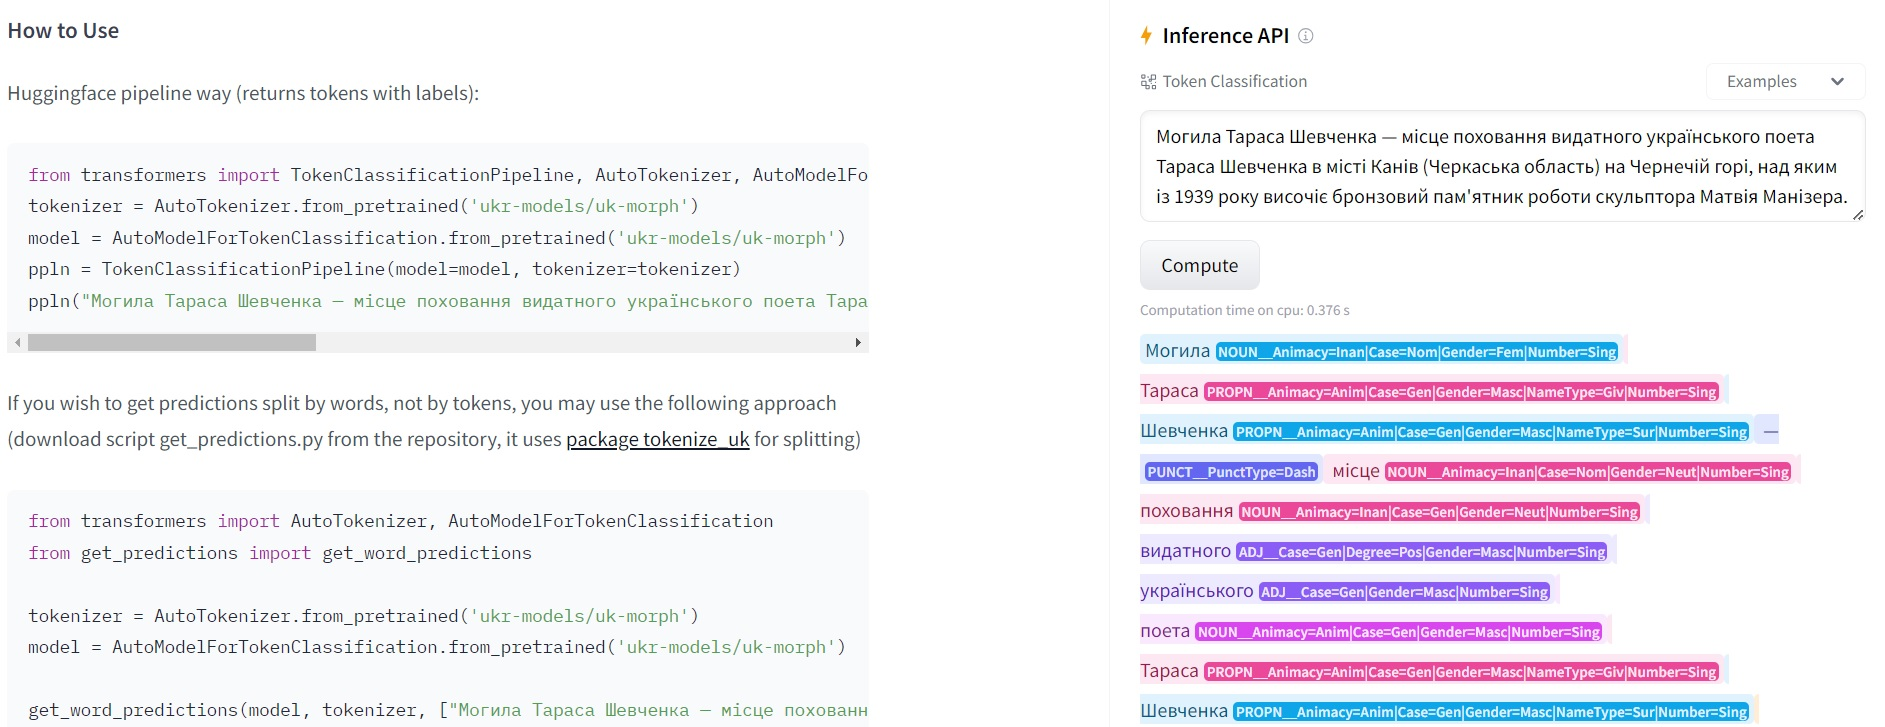

Взагалі на ресурсі HuggingFace є 11 моделей за запитом: ukr-models. Вони наведені на скриншоті нижче.

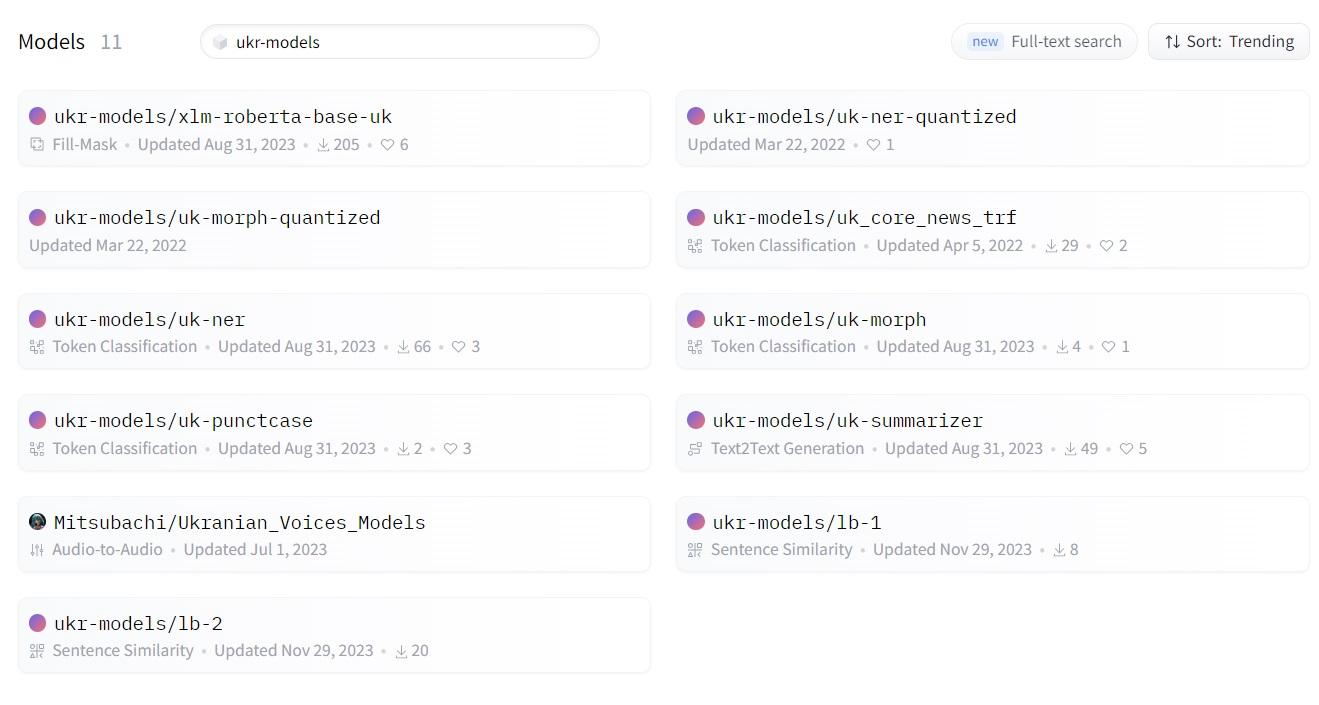

3. Завдання щодо генерації або стилізації зображень

In [22]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import tensorflow as tf
from keras.applications import vgg19

In [43]:
base_image_path = "D:/Універ/магістратура/1 семестр/Data Analysis/lab 4/mountain1.jpg"
style_reference_image_path = "D:/Універ/магістратура/1 семестр/Data Analysis/lab 4/mountain2.jpg"
result_prefix = "mountain_generated"


total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

width, height = keras.utils.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

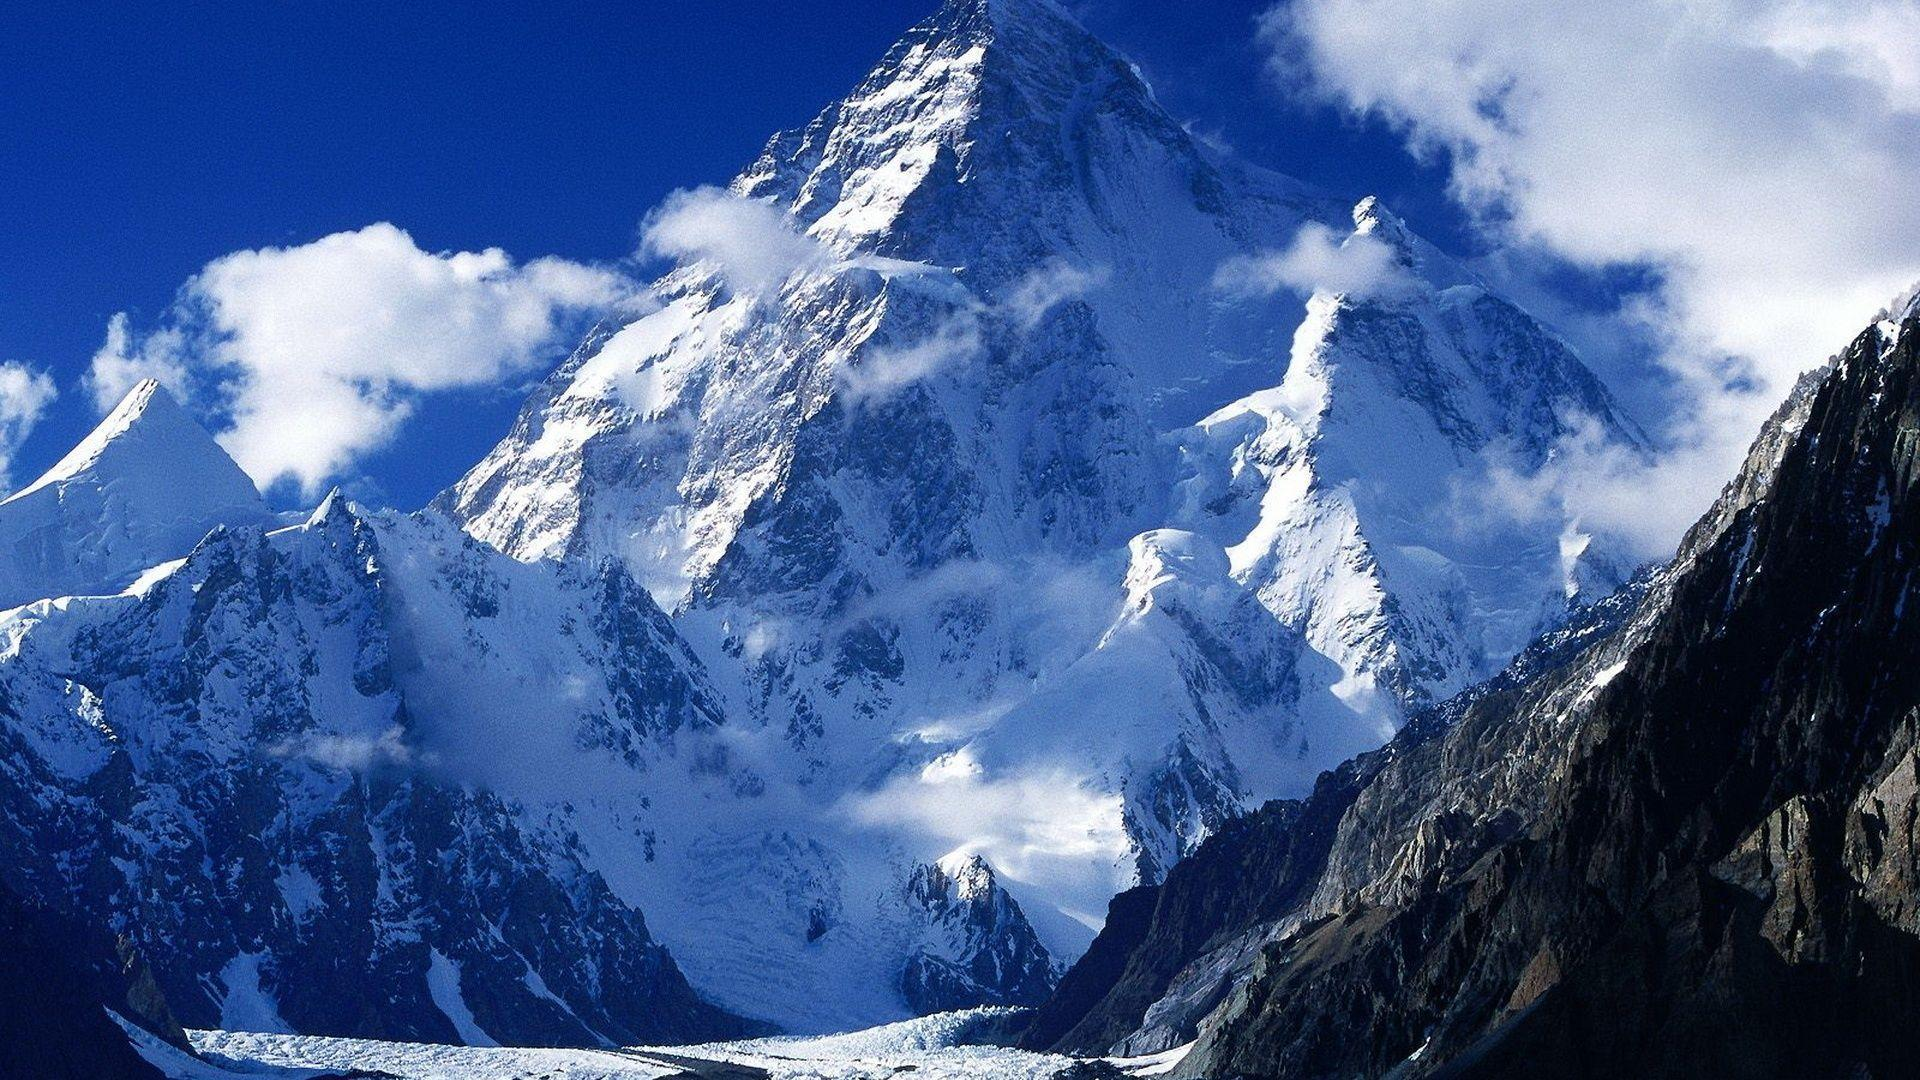

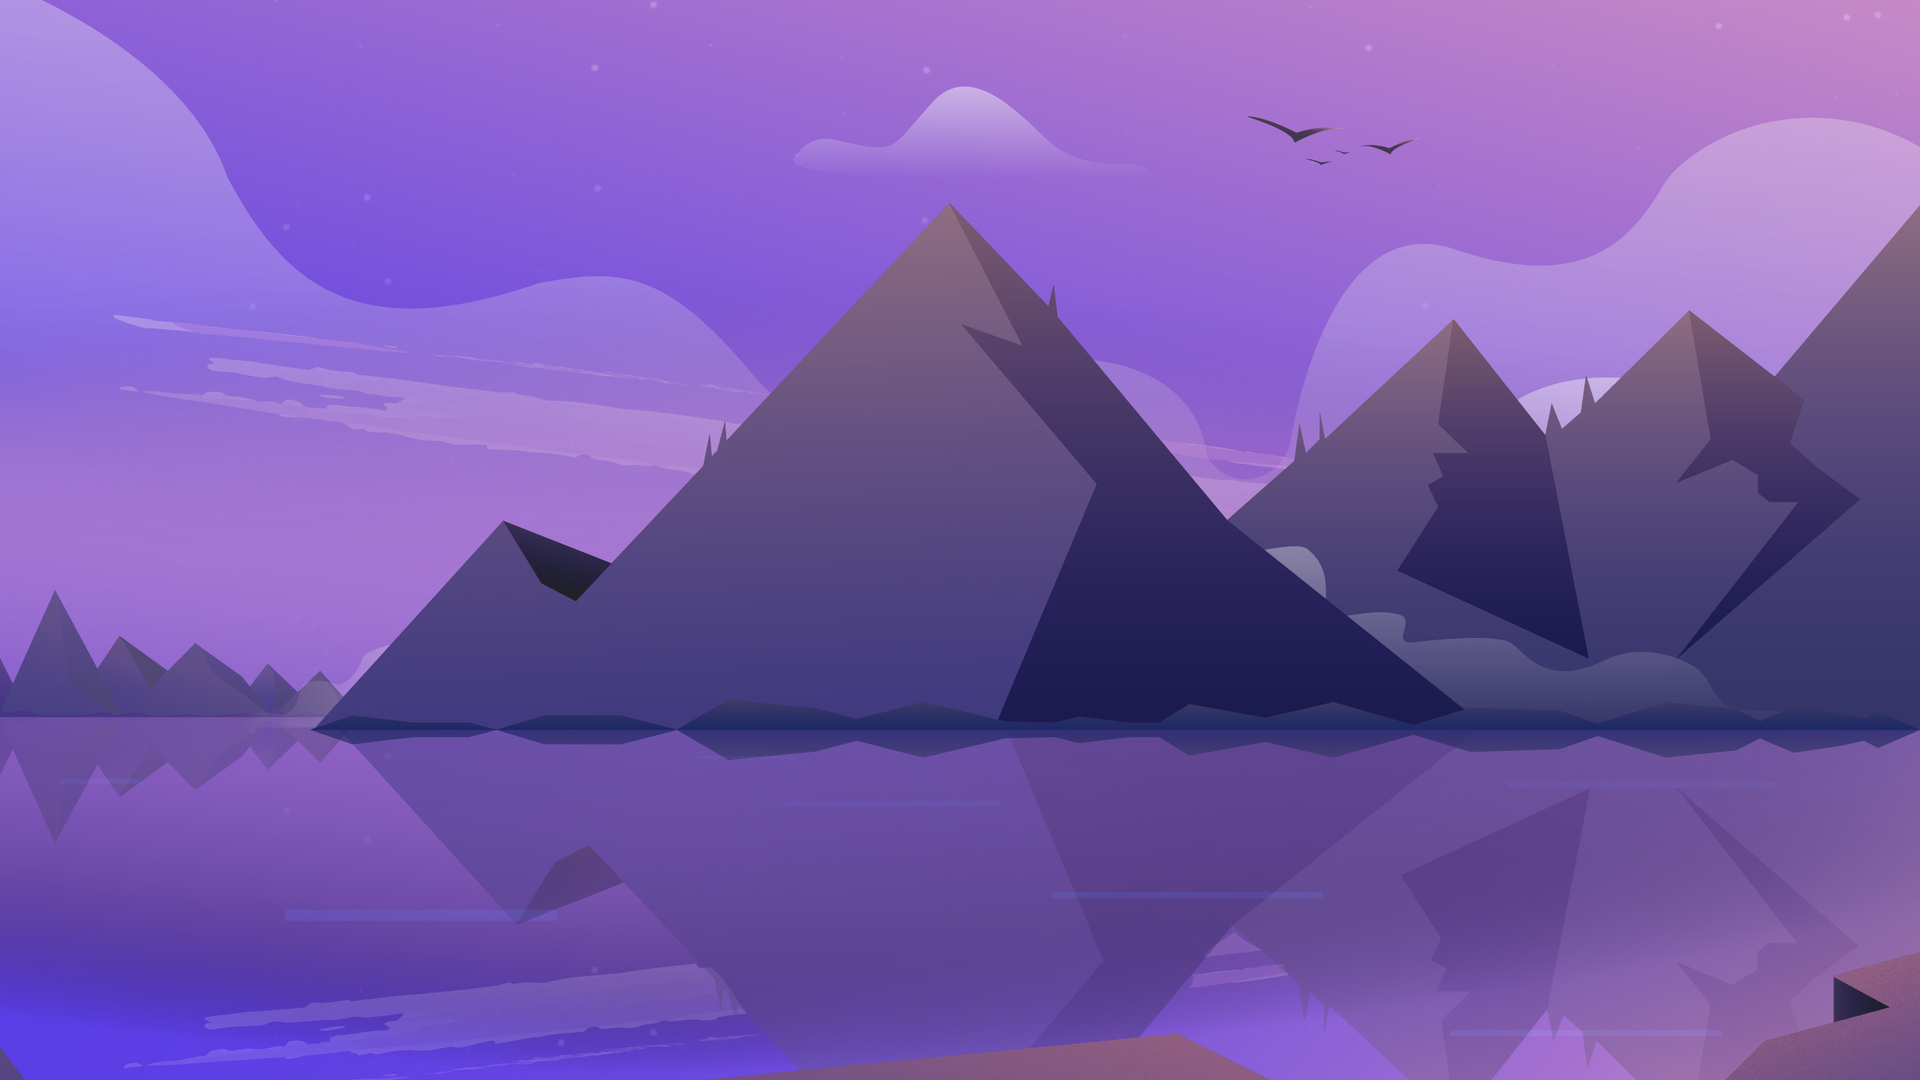

In [44]:
from IPython.display import Image, display

display(Image(base_image_path))
display(Image(style_reference_image_path))

In [45]:
def preprocess_image(image_path):
    img = keras.utils.load_img(image_path, target_size=(img_nrows, img_ncols))
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

In [46]:
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels**2) * (size**2))

def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))

def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [47]:
model = vgg19.VGG19(weights="imagenet", include_top=False)
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

In [48]:
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]

content_layer_name = "block5_conv2"

def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    loss = tf.zeros(shape=())

    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(base_image_features, combination_features)

    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

In [49]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

In [50]:
optimizer = keras.optimizers.SGD(keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96))

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 1000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.utils.save_img(fname, img)

Iteration 100: loss=3550.17
Iteration 200: loss=2140.32
Iteration 300: loss=1686.90
Iteration 400: loss=1452.11
Iteration 500: loss=1300.07
Iteration 600: loss=1189.71
Iteration 700: loss=1102.95
Iteration 800: loss=1031.63
Iteration 900: loss=971.68
Iteration 1000: loss=920.60


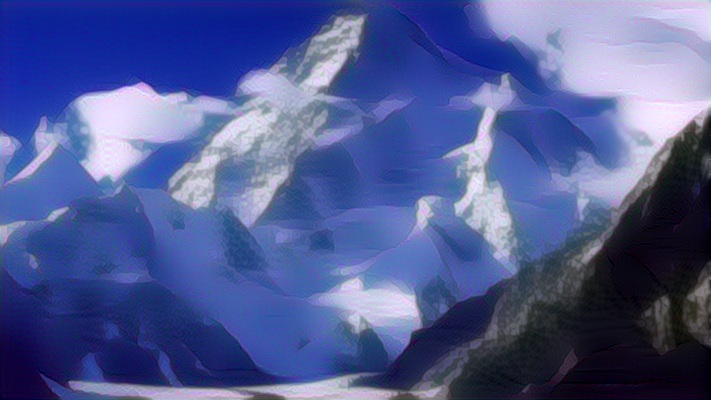

In [51]:
display(Image(result_prefix + "_at_iteration_1000.png"))